<a href="https://colab.research.google.com/github/O-Kpy/Kaggle/blob/main/tabular_playground_series_2021_aug_tabular_playground_series_aug_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import scipy
from scipy.stats import skew
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_test.csv')
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_sample_submission.csv')
train.shape, test.shape, submit.shape

((250000, 102), (150000, 101), (150000, 2))

In [ ]:
train['loss'].skew()  # target 라벨에 log1p씌울까 

1.4653191365369271

Text(0.5, 1.0, 'Train set Skew')

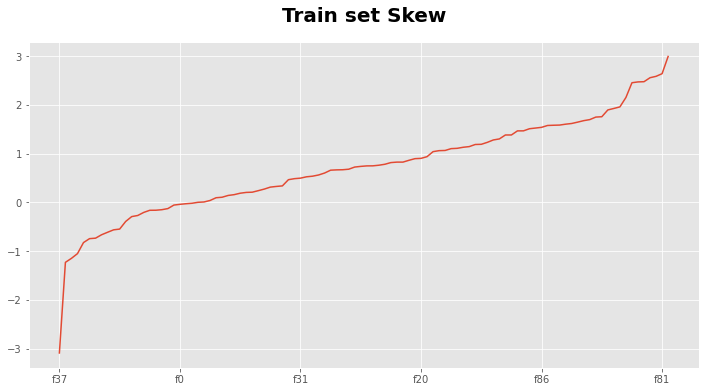

In [ ]:
plt.figure(figsize=(12,6))
train.skew().sort_values().plot()
plt.title('Train set Skew', fontsize=20, fontweight='bold', pad=20)
# noramlize를 적용 할까 고민

# cluster DBSCAN기법

- DBSCAN(density-based spatial clustering of application with noise)은 클러스터의 갯수를 미리 지정하지 않는 군집 알고리즘


- DBSCAN은 병합 군집이나 k-평균보다는 다소 느리지만 비교적 큰 데이터셋에도 적용



- 데이터의 밀집지역이 한 클러스터를 구성하며 비교적 비어있는 지역을 경계로 다른 클러스터와 구분함



- DBSCAN은 특성 공간에서 가까이 있는 데이터가 많아 붐비는 지역의 포인트를 찾음

- 이런 지역을 밀집 지역dense region이라 함

- 밀집 지역에 있는 포인트를 핵심 포인트core point라고함



- 핵심 포인트: min_samples, epsepsilon

  - 한 데이터 포인트에서 eps 거리 안에 데이터가 min_samples 갯수만큼 들어 있으면 이 데이터 포인트를 핵심 포인트로 분류

  - eps(거리)보다 가까운 핵심 샘플은 동일한 클러스터로 분류

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

data = pd.concat([train.drop(columns=['id']), test.drop(columns=['id'])], axis=0)
data_columns = data.columns

for i in data.columns:
  if i == 'loss':
    continue
  data[i] = MinMaxScaler().fit_transform(data[[i]])

In [ ]:
from sklearn.cluster import DBSCAN

data['cluster'] = DBSCAN(n_jobs=-1).fit_predict(data.drop(columns=['loss']))
data

KeyboardInterrupt: ignored

# Clustering 적용하자

In [3]:
!pip install catboost
!pip install optuna

     |████████████████████████████████| 67.4 MB 45 kB/s 
     |████████████████████████████████| 302 kB 8.0 MB/s 
     |████████████████████████████████| 80 kB 11.8 MB/s 
     |████████████████████████████████| 164 kB 71.6 MB/s 
     |████████████████████████████████| 75 kB 4.8 MB/s 
     |████████████████████████████████| 141 kB 63.0 MB/s 
     |████████████████████████████████| 49 kB 7.3 MB/s 
     |████████████████████████████████| 111 kB 68.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=3c8ba5ad1eda996d9d7c87525f58259e9ca2805f6af607f9bf9c6dd90ded5fef
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [4]:
import catboost
import optuna
import optuna.integration.lightgbm as lgbo
import lightgbm
import xgboost
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneGroupOut, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [5]:
# 데이터 나누기
x_train = train.drop(columns=['id', 'loss'])
y_train = train['loss']
x_test = test.drop(columns=['id'])
x_train_columns = x_train.columns
x_test_columns = x_test.columns
x_train.shape, y_train.shape, x_test.shape

((250000, 100), (250000,), (150000, 100))

In [6]:
mm = MinMaxScaler().fit(x_train)
x_train = mm.transform(x_train)
x_test = mm.transform(x_test)

x_train = pd.DataFrame(x_train, columns=x_train_columns)
x_test = pd.DataFrame(x_test, columns=x_test_columns)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'elbow method')

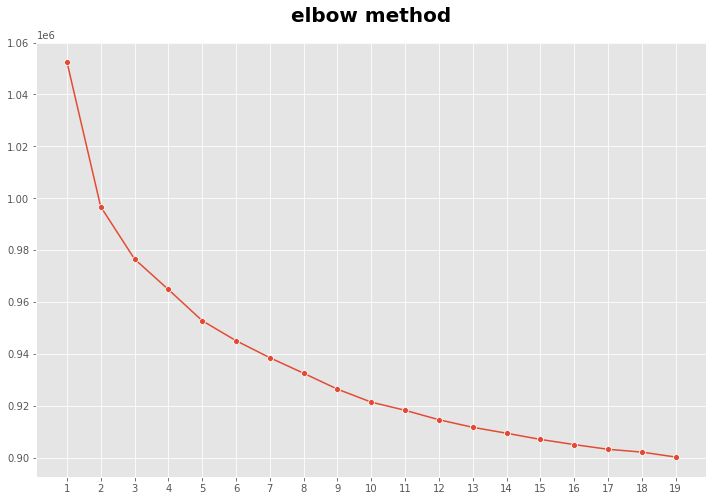

In [ ]:
# Clustering
from sklearn.cluster import KMeans

vstack = np.vstack((x_train,
                    x_test))

sse = {}
for i in range(1,20, 1):
  km = KMeans(n_clusters=i, max_iter=1000, random_state=0, n_jobs=-1).fit(vstack)
  sse[i] = km.inertia_

plt.figure(figsize=(12,8))
sns.lineplot(pd.Series(sse).index, pd.Series(sse), marker='o')
plt.xticks(pd.Series(sse).index)
plt.title('elbow method', fontsize=20, fontweight='bold', pad=20)

In [ ]:
km = KMeans(n_splits=, max_iter=1000, n_jobs=-1).fit(vstack)

x_train['cluster'] = km.predict(x_train)
x_test['cluster'] = km.predict(x_test)

In [ ]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))

for i, (train_index, valid_index) in enumerate(kf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostRegressor(iterations=3000, learning_rate=0.022, loss_function='RMSE', eval_metric='RMSE', task_type='GPU')
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)

  preds += np.expm1(model_cat.predict(x_test)) / kf.n_splits

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 1.1039045	test: 1.1063753	best: 1.1063753 (0)	total: 10.3ms	remaining: 30.9s
100:	learn: 1.0945647	test: 1.0977858	best: 1.0977858 (100)	total: 1.8s	remaining: 51.6s
200:	learn: 1.0901819	test: 1.0942911	best: 1.0942911 (200)	total: 2.91s	remaining: 40.6s
300:	learn: 1.0869794	test: 1.0920953	best: 1.0920953 (300)	total: 4.21s	remaining: 37.7s
400:	learn: 1.0843921	test: 1.0905177	best: 1.0905177 (400)	total: 5.58s	remaining: 36.2s
500:	learn: 1.0821666	test: 1.0893155	best: 1.0893155 (500)	total: 7.41s	remaining: 37s
600:	learn: 1.0800835	test: 1.0882926	best: 1.0882926 (600)	total: 9.82s	remaining: 39.2s
700:	learn: 1.0781490	test: 1.0874149	best: 1.0874149 (700)	total: 12.1s	remaining: 39.7s
800:	learn: 1.0763697	test: 1.0866818	best: 1.0866818 (800)	total: 14.4s	remaining: 39.6s
900:	learn: 1.0746677	test: 1.0860741	best: 1.0860741 (900)	total: 16.9s	remaining: 39.3s
1000:	learn: 1.0730308	test: 1.0855342	best: 1.0855342 (1000)	total: 18.9s	remaining: 37.8s
1100:	learn: 1

# LGBM LB: 7.90478

In [7]:
params = {'objective':'poisson', 'metric': 'rmse'} #'objective': 'mean_squared_error',
from sklearn.metrics import mean_absolute_error
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=42)
lgb_train = lightgbm.Dataset(X_train, Y_train)
lgb_valid = lightgbm.Dataset(X_test, Y_test)
model = lgbo.train(params, lgb_train, valid_sets=[lgb_valid], verbose_eval=False, num_boost_round=100, early_stopping_rounds=5) 
model.params

[I 2021-08-26 03:57:01,549] A new study created in memory with name: no-name-91f41e08-0153-4143-ae70-780db67f40cd
min_data_in_leaf, val_score: 7.871475: 100%|##########| 5/5 [01:03<00:00, 12.78s/it]


{'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'feature_fraction': 0.5,
 'feature_pre_filter': False,
 'lambda_l1': 1.8462648085726717e-08,
 'lambda_l2': 0.00010577357864252489,
 'metric': 'rmse',
 'min_child_samples': 100,
 'num_leaves': 121,
 'objective': 'poisson'}

In [8]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))
best_lgb_params = model.params
best_lgb_params["learning_rate"] = 0.006
best_lgb_params["num_iterations"] = 10000

for i, (train_index, valid_index) in enumerate(kf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_lgb = lightgbm.LGBMRegressor(**best_lgb_params)
  model_lgb.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_valid, Y_valid)], verbose=100, early_stopping_rounds=70)

  preds += model_lgb.predict(x_test) / kf.n_splits
  val_preds = model_lgb.predict(X_valid)
  RMSE = np.sqrt(mean_squared_error(val_preds, Y_valid))
  print(f'{i+1}번째 RMSE:{RMSE}')

Training until validation scores don't improve for 70 rounds.
[100]	training's rmse: 7.91408	valid_1's rmse: 7.90636
[200]	training's rmse: 7.88547	valid_1's rmse: 7.89585
[300]	training's rmse: 7.85868	valid_1's rmse: 7.88724
[400]	training's rmse: 7.8335	valid_1's rmse: 7.88015
[500]	training's rmse: 7.80925	valid_1's rmse: 7.87411
[600]	training's rmse: 7.78562	valid_1's rmse: 7.86884
[700]	training's rmse: 7.76264	valid_1's rmse: 7.86411
[800]	training's rmse: 7.74018	valid_1's rmse: 7.85976
[900]	training's rmse: 7.71803	valid_1's rmse: 7.85574
[1000]	training's rmse: 7.69621	valid_1's rmse: 7.85215
[1100]	training's rmse: 7.67473	valid_1's rmse: 7.84895
[1200]	training's rmse: 7.65363	valid_1's rmse: 7.8462
[1300]	training's rmse: 7.63279	valid_1's rmse: 7.84348
[1400]	training's rmse: 7.61225	valid_1's rmse: 7.84116
[1500]	training's rmse: 7.59184	valid_1's rmse: 7.83896
[1600]	training's rmse: 7.57167	valid_1's rmse: 7.83698
[1700]	training's rmse: 7.55166	valid_1's rmse: 7.835

# XGBoost LB: 

In [9]:
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {
        'max_depth': trial.suggest_int('max_depth', 4, 12), # Extremely prone to overfitting!
        'n_estimators': trial.suggest_int('n_estimators', 400, 4000, 400), # Extremely prone to overfitting!
        'eta': trial.suggest_float('eta', 0.007, 0.013), # Most important parameter.
        'subsample': trial.suggest_discrete_uniform('subsample', 0.2, 0.9, 0.1),
        'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.2, 0.9, 0.1),
        'colsample_bylevel': trial.suggest_discrete_uniform('colsample_bylevel', 0.2, 0.9, 0.1),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-4, 1e4), # I've had trouble with LB score until tuning this.
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1e4), # L2 regularization
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1e4), # L1 regularization
        'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),
        'tree_method' : 'gpu_hist',
        'booster' : 'gbtree',
        'loss_function':'rmse',
        'eval_metric':'rmse'
     }

    model = xgboost.XGBRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    RMSE = np.sqrt(mean_squared_error(y_test, y_preds))
    
    return RMSE

In [10]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-08-26 04:59:17,327] A new study created in memory with name: no-name-a1af6867-b87e-4cfa-bd3a-14d3ab517145


[04:59:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 04:59:21,390] Trial 0 finished with value: 7.866893582508445 and parameters: {'max_depth': 8, 'n_estimators': 2800, 'eta': 0.007731705960679655, 'subsample': 0.7, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.9, 'min_child_weight': 0.00013108887901699335, 'reg_lambda': 0.37415096463767766, 'reg_alpha': 0.00025136516446010935, 'gamma': 0.15677605529358743}. Best is trial 0 with value: 7.866893582508445.


[04:59:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 04:59:24,707] Trial 1 finished with value: 7.842650093738017 and parameters: {'max_depth': 6, 'n_estimators': 1600, 'eta': 0.007318046612862839, 'subsample': 0.8, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.4, 'min_child_weight': 0.004782557350639326, 'reg_lambda': 0.0005048439541642248, 'reg_alpha': 0.14231438241545202, 'gamma': 17.09181073377396}. Best is trial 1 with value: 7.842650093738017.


[04:59:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 04:59:27,542] Trial 2 finished with value: 7.862924889888162 and parameters: {'max_depth': 7, 'n_estimators': 2400, 'eta': 0.008542108668316341, 'subsample': 0.4, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.7, 'min_child_weight': 15.445596057999607, 'reg_lambda': 0.9467867245605908, 'reg_alpha': 0.02280706446927426, 'gamma': 0.0807277153370674}. Best is trial 1 with value: 7.842650093738017.


[04:59:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 04:59:34,930] Trial 3 finished with value: 7.827226046361868 and parameters: {'max_depth': 8, 'n_estimators': 1600, 'eta': 0.01277631063106923, 'subsample': 0.7, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.4, 'min_child_weight': 883.2401766636618, 'reg_lambda': 0.00015802265354670383, 'reg_alpha': 2515.7453106991743, 'gamma': 2.796650453766299}. Best is trial 3 with value: 7.827226046361868.


[04:59:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 04:59:38,549] Trial 4 finished with value: 7.827416860694847 and parameters: {'max_depth': 4, 'n_estimators': 2400, 'eta': 0.008879384803764314, 'subsample': 0.7, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.4, 'min_child_weight': 0.03906298266888185, 'reg_lambda': 0.006398780368884789, 'reg_alpha': 0.375521440221516, 'gamma': 1532.8030149898605}. Best is trial 3 with value: 7.827226046361868.


[04:59:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 04:59:45,152] Trial 5 finished with value: 7.925745445594223 and parameters: {'max_depth': 11, 'n_estimators': 3200, 'eta': 0.00829054828600385, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.2, 'min_child_weight': 0.21163061362369492, 'reg_lambda': 0.9050451332617381, 'reg_alpha': 0.0001082183227270008, 'gamma': 136.38140369711977}. Best is trial 3 with value: 7.827226046361868.


[04:59:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 04:59:49,747] Trial 6 finished with value: 7.874673777996951 and parameters: {'max_depth': 9, 'n_estimators': 2000, 'eta': 0.008777126363686601, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.30000000000000004, 'colsample_bylevel': 0.2, 'min_child_weight': 0.00011377218986356672, 'reg_lambda': 0.008867536760215835, 'reg_alpha': 15.587230813020964, 'gamma': 0.0016676349137221573}. Best is trial 3 with value: 7.827226046361868.


[04:59:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 04:59:57,316] Trial 7 finished with value: 7.897075143897948 and parameters: {'max_depth': 11, 'n_estimators': 800, 'eta': 0.010153538628691516, 'subsample': 0.9, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.9, 'min_child_weight': 0.00036195576870017373, 'reg_lambda': 0.00013149924166495555, 'reg_alpha': 0.21255665235228766, 'gamma': 0.3748407483747575}. Best is trial 3 with value: 7.827226046361868.


[04:59:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:00:00,748] Trial 8 finished with value: 7.826643923930981 and parameters: {'max_depth': 5, 'n_estimators': 1600, 'eta': 0.012007571383568498, 'subsample': 0.9, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.2, 'min_child_weight': 0.17050833781063818, 'reg_lambda': 36.02263513818296, 'reg_alpha': 0.0010420349867435305, 'gamma': 184.55314859937388}. Best is trial 8 with value: 7.826643923930981.


[05:00:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:00:04,401] Trial 9 finished with value: 7.832621627637712 and parameters: {'max_depth': 5, 'n_estimators': 1600, 'eta': 0.011524939470339963, 'subsample': 0.4, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.9, 'min_child_weight': 0.011340995573059369, 'reg_lambda': 1.1053137806989877, 'reg_alpha': 486.8958231506735, 'gamma': 668.1853690734587}. Best is trial 8 with value: 7.826643923930981.


[05:00:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:00:09,357] Trial 10 finished with value: 7.819361031405092 and parameters: {'max_depth': 4, 'n_estimators': 4000, 'eta': 0.012815475010908775, 'subsample': 0.9, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 10.766864444009338, 'reg_lambda': 4785.125286010345, 'reg_alpha': 0.0005787247849752029, 'gamma': 0.002166421205009889}. Best is trial 10 with value: 7.819361031405092.


[05:00:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:00:16,915] Trial 11 finished with value: 7.8186871059690395 and parameters: {'max_depth': 4, 'n_estimators': 4000, 'eta': 0.01293192393105599, 'subsample': 0.9, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 6.499580000126468, 'reg_lambda': 9193.045668323148, 'reg_alpha': 0.002814330239441946, 'gamma': 0.00036230002050774245}. Best is trial 11 with value: 7.8186871059690395.


[05:00:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:00:22,031] Trial 12 finished with value: 7.8211072742362076 and parameters: {'max_depth': 4, 'n_estimators': 4000, 'eta': 0.01093268172822438, 'subsample': 0.9, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 3.5322451658448397, 'reg_lambda': 8256.805286812714, 'reg_alpha': 0.008110932188208917, 'gamma': 0.0003646343614463895}. Best is trial 11 with value: 7.8186871059690395.


[05:00:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:00:28,413] Trial 13 finished with value: 7.819635139429757 and parameters: {'max_depth': 6, 'n_estimators': 4000, 'eta': 0.012913780837879937, 'subsample': 0.8, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'min_child_weight': 97.4878493197309, 'reg_lambda': 7000.76296086793, 'reg_alpha': 0.0035096945731768023, 'gamma': 0.004717896608479992}. Best is trial 11 with value: 7.8186871059690395.


[05:00:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:00:32,551] Trial 14 finished with value: 7.838688006863682 and parameters: {'max_depth': 4, 'n_estimators': 3600, 'eta': 0.011816541669890431, 'subsample': 0.5, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 8036.013702283261, 'reg_lambda': 310.92357385568323, 'reg_alpha': 7.5068536481947, 'gamma': 0.00011497054168305179}. Best is trial 11 with value: 7.8186871059690395.


[05:00:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:00:35,378] Trial 15 finished with value: 7.848117822218135 and parameters: {'max_depth': 6, 'n_estimators': 3200, 'eta': 0.01036870720797454, 'subsample': 0.2, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.5, 'min_child_weight': 39.62480206640403, 'reg_lambda': 330.23581540058143, 'reg_alpha': 0.02408978427170947, 'gamma': 0.011926165031143271}. Best is trial 11 with value: 7.8186871059690395.


[05:00:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:00:44,419] Trial 16 finished with value: 7.83129898772258 and parameters: {'max_depth': 10, 'n_estimators': 3600, 'eta': 0.012352419767562848, 'subsample': 0.8, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'min_child_weight': 3.1444585936537615, 'reg_lambda': 589.9141853725646, 'reg_alpha': 0.0005427890417692525, 'gamma': 0.0008648487987344572}. Best is trial 11 with value: 7.8186871059690395.


[05:00:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:00:47,221] Trial 17 finished with value: 7.833050869794303 and parameters: {'max_depth': 5, 'n_estimators': 400, 'eta': 0.010857060330791927, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.5, 'min_child_weight': 234.98371953210494, 'reg_lambda': 18.827419156597028, 'reg_alpha': 2.0520207726609225, 'gamma': 0.02564957003760097}. Best is trial 11 with value: 7.8186871059690395.


[05:00:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:00:52,787] Trial 18 finished with value: 7.821070637740032 and parameters: {'max_depth': 7, 'n_estimators': 4000, 'eta': 0.00954454574360737, 'subsample': 0.9, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.8, 'min_child_weight': 0.950233107246481, 'reg_lambda': 2361.2382290590867, 'reg_alpha': 0.0019489654547525132, 'gamma': 0.00015127621560106415}. Best is trial 11 with value: 7.8186871059690395.


[05:00:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:00:56,514] Trial 19 finished with value: 7.834424995134445 and parameters: {'max_depth': 12, 'n_estimators': 3200, 'eta': 0.01117639821921331, 'subsample': 0.8, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 1032.2614637212723, 'reg_lambda': 29.53484504739015, 'reg_alpha': 0.031939232223255155, 'gamma': 3.9403350731417737}. Best is trial 11 with value: 7.8186871059690395.


[05:00:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:01:00,726] Trial 20 finished with value: 7.824771778964954 and parameters: {'max_depth': 4, 'n_estimators': 3600, 'eta': 0.012425723802289188, 'subsample': 0.5, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.8, 'min_child_weight': 9.424053306606801, 'reg_lambda': 1184.0870013632752, 'reg_alpha': 0.00013742825121331796, 'gamma': 0.004216301716812663}. Best is trial 11 with value: 7.8186871059690395.


[05:01:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:01:07,026] Trial 21 finished with value: 7.8200556949698745 and parameters: {'max_depth': 6, 'n_estimators': 4000, 'eta': 0.012976842576422848, 'subsample': 0.8, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'min_child_weight': 106.65797887037766, 'reg_lambda': 7909.281563752283, 'reg_alpha': 0.005545412278092049, 'gamma': 0.0037336562898546395}. Best is trial 11 with value: 7.8186871059690395.


[05:01:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:01:10,658] Trial 22 finished with value: 7.826217924519117 and parameters: {'max_depth': 5, 'n_estimators': 4000, 'eta': 0.012972803229361448, 'subsample': 0.9, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'min_child_weight': 1.0335233540713926, 'reg_lambda': 99.51324452639504, 'reg_alpha': 0.0021610695579826313, 'gamma': 0.027026400611829655}. Best is trial 11 with value: 7.8186871059690395.


[05:01:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:01:18,640] Trial 23 finished with value: 7.822833270513787 and parameters: {'max_depth': 7, 'n_estimators': 3600, 'eta': 0.012284136297310438, 'subsample': 0.8, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'min_child_weight': 181.81205899414377, 'reg_lambda': 8516.47069404068, 'reg_alpha': 0.004861288771338801, 'gamma': 0.0008815087226776321}. Best is trial 11 with value: 7.8186871059690395.


[05:01:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:01:23,691] Trial 24 finished with value: 7.822655492748104 and parameters: {'max_depth': 6, 'n_estimators': 2800, 'eta': 0.011614623038579021, 'subsample': 0.7, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.8, 'min_child_weight': 37.51686270232026, 'reg_lambda': 2318.8668340106024, 'reg_alpha': 0.06711271250916362, 'gamma': 0.007741385578479839}. Best is trial 11 with value: 7.8186871059690395.


[05:01:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:01:26,921] Trial 25 finished with value: 7.825766926945071 and parameters: {'max_depth': 5, 'n_estimators': 4000, 'eta': 0.01259065706628947, 'subsample': 0.9, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 1086.8660111514478, 'reg_lambda': 5.324595498813332, 'reg_alpha': 0.0006254569932766768, 'gamma': 0.000476136459603371}. Best is trial 11 with value: 7.8186871059690395.


[05:01:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:01:30,959] Trial 26 finished with value: 7.82472285949321 and parameters: {'max_depth': 4, 'n_estimators': 2800, 'eta': 0.012125581566236913, 'subsample': 0.8, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.30000000000000004, 'min_child_weight': 4.2650192059982945, 'reg_lambda': 159.17389664187422, 'reg_alpha': 0.9771530512178213, 'gamma': 0.04390630950067311}. Best is trial 11 with value: 7.8186871059690395.


[05:01:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:01:36,365] Trial 27 finished with value: 7.8235616431124 and parameters: {'max_depth': 5, 'n_estimators': 3600, 'eta': 0.011343997563771198, 'subsample': 0.9, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'min_child_weight': 6215.747952521499, 'reg_lambda': 1688.4513785747508, 'reg_alpha': 79.85129612167489, 'gamma': 0.0025676996988299085}. Best is trial 11 with value: 7.8186871059690395.


[05:01:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:01:39,226] Trial 28 finished with value: 7.849748128346408 and parameters: {'max_depth': 6, 'n_estimators': 3200, 'eta': 0.012637458482605066, 'subsample': 0.6000000000000001, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.5, 'min_child_weight': 0.4529717267145952, 'reg_lambda': 0.0821564373777766, 'reg_alpha': 0.007280558514265209, 'gamma': 0.0001073861661101372}. Best is trial 11 with value: 7.8186871059690395.


[05:01:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:01:42,536] Trial 29 finished with value: 7.844781585960946 and parameters: {'max_depth': 8, 'n_estimators': 4000, 'eta': 0.00955622049346745, 'subsample': 0.7, 'colsample_bytree': 0.6000000000000001, 'colsample_bylevel': 0.8, 'min_child_weight': 29.177678791492692, 'reg_lambda': 5.958698174191208, 'reg_alpha': 0.0002545681219074912, 'gamma': 0.3170076273304689}. Best is trial 11 with value: 7.8186871059690395.


[05:01:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:01:47,594] Trial 30 finished with value: 7.820832847817668 and parameters: {'max_depth': 4, 'n_estimators': 3200, 'eta': 0.010646902016026447, 'subsample': 0.7, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 96.08043127771778, 'reg_lambda': 3278.9144458634905, 'reg_alpha': 0.00041502018488542505, 'gamma': 0.14652355652713828}. Best is trial 11 with value: 7.8186871059690395.


[05:01:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:01:54,897] Trial 31 finished with value: 7.8216685129108505 and parameters: {'max_depth': 8, 'n_estimators': 4000, 'eta': 0.012626828296708642, 'subsample': 0.8, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'min_child_weight': 335.47688351910654, 'reg_lambda': 6057.9068347483935, 'reg_alpha': 0.0033986951833268903, 'gamma': 0.006382859682473367}. Best is trial 11 with value: 7.8186871059690395.


[05:01:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:02:00,338] Trial 32 finished with value: 7.823755270913563 and parameters: {'max_depth': 7, 'n_estimators': 3600, 'eta': 0.012978541479985407, 'subsample': 0.8, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'min_child_weight': 77.09212819953983, 'reg_lambda': 1252.184925391233, 'reg_alpha': 0.012262847183890755, 'gamma': 0.002003021315469512}. Best is trial 11 with value: 7.8186871059690395.


[05:02:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:02:08,051] Trial 33 finished with value: 7.818687507871604 and parameters: {'max_depth': 6, 'n_estimators': 4000, 'eta': 0.011899607859428592, 'subsample': 0.8, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 13.697832082413017, 'reg_lambda': 9671.826080828288, 'reg_alpha': 0.06054268599396245, 'gamma': 0.0004719969169064117}. Best is trial 11 with value: 7.8186871059690395.


[05:02:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:02:12,598] Trial 34 finished with value: 7.822831450524895 and parameters: {'max_depth': 7, 'n_estimators': 3600, 'eta': 0.011854422657043302, 'subsample': 0.9, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 9.501724794225451, 'reg_lambda': 856.6505390889444, 'reg_alpha': 0.08359946958330464, 'gamma': 0.0003926064155443721}. Best is trial 11 with value: 7.8186871059690395.


[05:02:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:02:16,659] Trial 35 finished with value: 7.82626588354864 and parameters: {'max_depth': 5, 'n_estimators': 4000, 'eta': 0.007080741970373962, 'subsample': 0.7, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.4, 'min_child_weight': 16.245713901709042, 'reg_lambda': 210.031294725178, 'reg_alpha': 0.0016317931463722987, 'gamma': 0.0002865548892953602}. Best is trial 11 with value: 7.8186871059690395.


[05:02:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:02:27,647] Trial 36 finished with value: 7.823331951784784 and parameters: {'max_depth': 9, 'n_estimators': 2400, 'eta': 0.012036415082856022, 'subsample': 0.8, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'min_child_weight': 2.0124412903290576, 'reg_lambda': 3887.5295348250193, 'reg_alpha': 0.03715197304962679, 'gamma': 0.0011010616793041559}. Best is trial 11 with value: 7.8186871059690395.


[05:02:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:02:30,939] Trial 37 finished with value: 7.833735511537183 and parameters: {'max_depth': 6, 'n_estimators': 1200, 'eta': 0.01240832364355562, 'subsample': 0.9, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 0.06329143335201402, 'reg_lambda': 93.48143698399431, 'reg_alpha': 0.1921265635465824, 'gamma': 0.011550226227563453}. Best is trial 11 with value: 7.8186871059690395.


[05:02:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:02:34,321] Trial 38 finished with value: 7.827893587749045 and parameters: {'max_depth': 4, 'n_estimators': 2800, 'eta': 0.012681984532750493, 'subsample': 0.7, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.4, 'min_child_weight': 405.04351775524094, 'reg_lambda': 0.0014570279656720435, 'reg_alpha': 0.6192259286323135, 'gamma': 9.65294432928731}. Best is trial 11 with value: 7.8186871059690395.


[05:02:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:02:41,975] Trial 39 finished with value: 7.832471787291079 and parameters: {'max_depth': 9, 'n_estimators': 3200, 'eta': 0.011675333582539518, 'subsample': 0.8, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'min_child_weight': 14.179586104902716, 'reg_lambda': 626.7201406820033, 'reg_alpha': 0.01797616061583715, 'gamma': 0.06332637551702315}. Best is trial 11 with value: 7.8186871059690395.


[05:02:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:02:45,501] Trial 40 finished with value: 7.824468219115166 and parameters: {'max_depth': 6, 'n_estimators': 2000, 'eta': 0.007674471863420347, 'subsample': 0.9, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'min_child_weight': 2422.333751054142, 'reg_lambda': 0.07114890521021948, 'reg_alpha': 0.0009445371995876823, 'gamma': 0.46814810273850466}. Best is trial 11 with value: 7.8186871059690395.


[05:02:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:02:52,541] Trial 41 finished with value: 7.819909288885774 and parameters: {'max_depth': 6, 'n_estimators': 4000, 'eta': 0.012948152923501722, 'subsample': 0.8, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.8, 'min_child_weight': 104.46866462984393, 'reg_lambda': 8132.62286214905, 'reg_alpha': 0.002624544258339626, 'gamma': 0.0035990051272477277}. Best is trial 11 with value: 7.8186871059690395.


[05:02:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:03:01,035] Trial 42 finished with value: 7.821929775506962 and parameters: {'max_depth': 7, 'n_estimators': 4000, 'eta': 0.012745915640110008, 'subsample': 0.8, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'min_child_weight': 7.782001569052575, 'reg_lambda': 9871.005128696965, 'reg_alpha': 0.00011971788934792171, 'gamma': 0.0013183748841780793}. Best is trial 11 with value: 7.8186871059690395.


[05:03:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:03:07,499] Trial 43 finished with value: 7.819584807089038 and parameters: {'max_depth': 5, 'n_estimators': 3600, 'eta': 0.01235220609078525, 'subsample': 0.9, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.8, 'min_child_weight': 48.84498621451141, 'reg_lambda': 3544.4085303628544, 'reg_alpha': 0.0029493378852335516, 'gamma': 0.0003108440444529418}. Best is trial 11 with value: 7.8186871059690395.


[05:03:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:03:12,630] Trial 44 finished with value: 7.827222970380526 and parameters: {'max_depth': 5, 'n_estimators': 3600, 'eta': 0.012159079484292686, 'subsample': 0.9, 'colsample_bytree': 0.2, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 42.97306341650916, 'reg_lambda': 1964.9141079739484, 'reg_alpha': 0.07206359547049326, 'gamma': 0.0003109830263831126}. Best is trial 11 with value: 7.8186871059690395.


[05:03:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:03:16,497] Trial 45 finished with value: 7.822415862415178 and parameters: {'max_depth': 4, 'n_estimators': 3600, 'eta': 0.012006204574171953, 'subsample': 0.9, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.8, 'min_child_weight': 1.5928591976486757, 'reg_lambda': 552.4049019589826, 'reg_alpha': 0.0002819413616385151, 'gamma': 8017.46877546468}. Best is trial 11 with value: 7.8186871059690395.


[05:03:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:03:20,975] Trial 46 finished with value: 7.82172489061164 and parameters: {'max_depth': 5, 'n_estimators': 4000, 'eta': 0.012451637253883489, 'subsample': 0.9, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'min_child_weight': 5.665935581985069, 'reg_lambda': 410.90751800335676, 'reg_alpha': 0.012325667392138683, 'gamma': 0.0006656402509387072}. Best is trial 11 with value: 7.8186871059690395.


[05:03:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:03:26,062] Trial 47 finished with value: 7.829296024566069 and parameters: {'max_depth': 5, 'n_estimators': 3600, 'eta': 0.01121391240209019, 'subsample': 0.4, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'min_child_weight': 0.00044611799143502647, 'reg_lambda': 3971.7253724457178, 'reg_alpha': 0.0010160193821041115, 'gamma': 0.00016591476895788733}. Best is trial 11 with value: 7.8186871059690395.


[05:03:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:03:29,411] Trial 48 finished with value: 7.823222254497042 and parameters: {'max_depth': 4, 'n_estimators': 4000, 'eta': 0.011826623457004169, 'subsample': 0.9, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 0.36755582401070075, 'reg_lambda': 64.79890246985399, 'reg_alpha': 4.829472753620886, 'gamma': 0.011642707440288603}. Best is trial 11 with value: 7.8186871059690395.


[05:03:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-08-26 05:03:33,781] Trial 49 finished with value: 7.845717394434312 and parameters: {'max_depth': 4, 'n_estimators': 3200, 'eta': 0.012300693624825032, 'subsample': 0.2, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'min_child_weight': 633.1548440656394, 'reg_lambda': 3619.8719424014644, 'reg_alpha': 0.38015181309310264, 'gamma': 85.09375145815423}. Best is trial 11 with value: 7.8186871059690395.


Number of finished trials: 50
Best trial: score 7.8186871059690395, params {'max_depth': 4, 'n_estimators': 4000, 'eta': 0.01293192393105599, 'subsample': 0.9, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.6000000000000001, 'min_child_weight': 6.499580000126468, 'reg_lambda': 9193.045668323148, 'reg_alpha': 0.002814330239441946, 'gamma': 0.00036230002050774245}


In [11]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))
params_xgb = {'booster' : 'gbtree',
              'tree_method' : 'gpu_hist',
              'loss_function':'rmse',
              'eval_metric':'rmse',
              'max_depth': study.best_params['max_depth'],
              'n_estimators': study.best_params['n_estimators'],
              'eta': study.best_params['eta'],
              'colsample_bytree': study.best_params['colsample_bytree'],
              'colsample_bylevel': study.best_params['colsample_bylevel'],
              'min_child_weight': study.best_params['min_child_weight'],
              'reg_lambda': study.best_params['reg_lambda'],
              'reg_alpha': study.best_params['reg_alpha'],
              'gamma': study.best_params['gamma'],
              'subsample': study.best_params['subsample']
          }

for i, (train_index, valid_index) in enumerate(sk.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_xgb = xgboost.XGBRegressor(**params_xgb)
  model_xgb.fit(X_train, Y_train, eval_set=((X_train, Y_train), (X_valid, Y_valid)), verbose=100, early_stopping_rounds=70)

  preds += model_xgb.predict(x_test) / sk.n_splits
  val_preds = model_xgb.predict(X_valid)
  RMSE = np.sqrt(mean_squared_error(Y_valid, val_preds))
  print(f'{i+1}번째 RMSE:{RMSE}')

[05:03:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:9.78049	validation_1-rmse:9.77932
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 70 rounds.
[100]	validation_0-rmse:7.8646	validation_1-rmse:7.88911
[200]	validation_0-rmse:7.82298	validation_1-rmse:7.8683
[300]	validation_0-rmse:7.79347	validation_1-rmse:7.858
[400]	validation_0-rmse:7.76947	validation_1-rmse:7.85176
[500]	validation_0-rmse:7.7488	validation_1-rmse:7.848
[600]	validation_0-rmse:7.72944	validation_1-rmse:7.84628
[700]	validation_0-rmse:7.71109	validation_1-rmse:7.84466
[800]	validation_0-rmse:7.69304	validation_1-rmse:7.84448
[900]	validation_0-rmse:7.67514	validation_1-rmse:7.8439
[1000]	validation_0-rmse:7.65711	validation_1-rmse:7.84368
Stopping. Best iteration:
[970]	validation_0-rmse:7.66249	validation_1-rmse:7.84358



# Catboost LB : 7.87727

In [12]:
cat_features = x_train.select_dtypes('object').columns
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 2000, 25000),
             'loss_function':'RMSE',
              'task_type':"GPU",
              'eval_metric':'RMSE',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,13),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'grow_policy' : 'Depthwise',
              'objective' : 'Poisson'
               }
    model = catboost.CatBoostRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    RMSE = np.sqrt(mean_squared_error(y_test, y_preds))
    
    return RMSE

In [13]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-08-26 05:04:17,775] A new study created in memory with name: no-name-284b615f-d159-4bec-b258-60d5caa42bd0
[I 2021-08-26 05:05:26,338] Trial 0 finished with value: 7.888872523451853 and parameters: {'iterations': 22335, 'learning_rate': 0.3676604116497724, 'reg_lambda': 11.204044822648553, 'subsample': 0.48221419322822834, 'random_strength': 34.09141603038662, 'depth': 8, 'min_data_in_leaf': 38, 'leaf_estimation_iterations': 8}. Best is trial 0 with value: 7.888872523451853.
[I 2021-08-26 05:05:40,804] Trial 1 finished with value: 7.829985955087066 and parameters: {'iterations': 5773, 'learning_rate': 0.335158668149151, 'reg_lambda': 38.54447263322012, 'subsample': 0.4834278242598392, 'random_strength': 36.52826890184317, 'depth': 1, 'min_data_in_leaf': 49, 'leaf_estimation_iterations': 13}. Best is trial 1 with value: 7.829985955087066.
[I 2021-08-26 05:05:46,207] Trial 2 finished with value: 7.852744258661823 and parameters: {'iterations': 11629, 'learning_rate': 0.18519057015

Number of finished trials: 50
Best trial: score 7.82338581606999, params {'iterations': 12181, 'learning_rate': 0.047224876730083326, 'reg_lambda': 0.5619893385164616, 'subsample': 0.4538781843092088, 'random_strength': 34.04332694887707, 'depth': 2, 'min_data_in_leaf': 20, 'leaf_estimation_iterations': 7}


In [14]:
sk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
preds = np.zeros((x_test.shape[0],))
params_cat = {'iterations':study.best_params['iterations'],
         'loss_function':'RMSE',
         'task_type':"GPU",
         'eval_metric':'RMSE',
         'leaf_estimation_method':'Newton',
         'bootstrap_type': 'Bernoulli',
         'learning_rate' : study.best_params['learning_rate'],
         'reg_lambda': study.best_params['reg_lambda'],
         'subsample': study.best_params['subsample'],
         'random_strength': study.best_params['random_strength'],
         'depth': study.best_params['depth'],
         'min_data_in_leaf': study.best_params['min_data_in_leaf'],
         'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
         'grow_policy' : 'Depthwise',  
}

for i, (train_index, valid_index) in enumerate(sk.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostRegressor(**params_cat)
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)

  preds += model_cat.predict(x_test) / sk.n_splits
  val_preds = model_cat.predict(X_valid)
  RMSE = np.sqrt(mean_squared_error(val_preds, Y_valid))
  print(f'{i+1}번째 RMSE:{RMSE}')

0:	learn: 7.9393954	test: 7.9385691	best: 7.9385691 (0)	total: 7.41ms	remaining: 1m 30s
100:	learn: 7.9073501	test: 7.9127236	best: 7.9127236 (100)	total: 614ms	remaining: 1m 13s
200:	learn: 7.8912246	test: 7.9003946	best: 7.9003946 (200)	total: 1.19s	remaining: 1m 11s
300:	learn: 7.8793889	test: 7.8910950	best: 7.8910950 (300)	total: 1.76s	remaining: 1m 9s
400:	learn: 7.8695108	test: 7.8840757	best: 7.8840757 (400)	total: 2.34s	remaining: 1m 8s
500:	learn: 7.8614852	test: 7.8783472	best: 7.8783472 (500)	total: 2.9s	remaining: 1m 7s
600:	learn: 7.8547954	test: 7.8747556	best: 7.8747556 (600)	total: 3.49s	remaining: 1m 7s
700:	learn: 7.8489614	test: 7.8712105	best: 7.8712105 (700)	total: 4.05s	remaining: 1m 6s
800:	learn: 7.8433937	test: 7.8675609	best: 7.8675609 (800)	total: 4.6s	remaining: 1m 5s
900:	learn: 7.8386179	test: 7.8651475	best: 7.8651475 (900)	total: 5.13s	remaining: 1m 4s
1000:	learn: 7.8342077	test: 7.8627708	best: 7.8627708 (1000)	total: 5.71s	remaining: 1m 3s
1100:	lear

# voting regressor

In [15]:
from sklearn.ensemble import VotingRegressor

In [16]:
cat = catboost.CatBoostRegressor(**params_cat)
lgb = lightgbm.LGBMRegressor(**best_lgb_params)
xgb = xgboost.XGBRegressor(**params_xgb)

In [17]:
from sklearn.ensemble import VotingRegressor
folds = KFold(n_splits = 10, random_state = 42, shuffle = True)

predictions = np.zeros((len(x_test),))

for fold, (trn_idx, val_idx) in enumerate(folds.split(x_train)):
    print(f"Fold: {fold}")
    X_train, X_val = x_train.values[trn_idx], x_train.values[val_idx]
    Y_train, Y_val = y_train.values[trn_idx], y_train.values[val_idx]

    model = VotingRegressor(
            estimators = [
                ('xgb', xgb),
                ('cat', cat),
                ('lgb', lgb)
            ],
            weights = [0.15, 0.7, 0.15]
        )
   
    model.fit(X_train, Y_train)
    pred = model.predict(X_val)
    error = mean_squared_error(Y_val, pred,squared = False)
    print(f" mean_squared_error: {error}")
    print("-"*50)
    
    predictions += model.predict(x_test) / folds.n_splits 

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
7183:	learn: 7.7301637	total: 42.7s	remaining: 29.7s
7184:	learn: 7.7301482	total: 42.7s	remaining: 29.7s
7185:	learn: 7.7301358	total: 42.7s	remaining: 29.7s
7186:	learn: 7.7301134	total: 42.7s	remaining: 29.7s
7187:	learn: 7.7301010	total: 42.7s	remaining: 29.7s
7188:	learn: 7.7300898	total: 42.7s	remaining: 29.7s
7189:	learn: 7.7300717	total: 42.8s	remaining: 29.7s
7190:	learn: 7.7300381	total: 42.8s	remaining: 29.7s
7191:	learn: 7.7300286	total: 42.8s	remaining: 29.7s
7192:	learn: 7.7300122	total: 42.8s	remaining: 29.7s
7193:	learn: 7.7300016	total: 42.8s	remaining: 29.7s
7194:	learn: 7.7299800	total: 42.8s	remaining: 29.6s
7195:	learn: 7.7299564	total: 42.8s	remaining: 29.6s
7196:	learn: 7.7299415	total: 42.8s	remaining: 29.6s
7197:	learn: 7.7299375	total: 42.8s	remaining: 29.6s
7198:	learn: 7.7299274	total: 42.8s	remaining: 29.6s
7199:	learn: 7.7299176	total: 42.8s	remaining: 29.6s
7200:	learn: 7.7299076	total: 42.8s	remaining: 29.6s
7201:	lear

# Stacking Regressor

In [ ]:
cat = catboost.CatBoostRegressor(**params_cat)
lgb = lightgbm.LGBMRegressor(**best_lgb_params)
xgb = xgboost.XGBRegressor(**params_xgb)

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Lasso, ElasticNet, LinearRegression

folds = KFold(n_splits = 10, random_state = 2021, shuffle = True)

predictions = np.zeros((len(x_test),))

for fold, (trn_idx, val_idx) in enumerate(folds.split(x_train)):
    print(f"Fold: {fold}")
    X_train, X_val = x_train.values[trn_idx], x_train.values[val_idx]
    Y_train, Y_val = y_train.values[trn_idx], y_train.values[val_idx]

    model = StackingRegressor(
            estimators = [
                ('xgb', xgb),
                ('cat', cat)
            ],
            final_estimator=lgb
        )
   
    model.fit(X_train, Y_train)
    pred = model.predict(X_val)
    error = mean_squared_error(Y_val, pred,squared = False)
    print(f" mean_squared_error: {error}")
    print("-"*50)
    
    predictions += model.predict(x_test) / folds.n_splits 

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1143:	learn: 7.6584855	total: 13.1s	remaining: 10.3s
1144:	learn: 7.6583234	total: 13.1s	remaining: 10.3s
1145:	learn: 7.6581583	total: 13.1s	remaining: 10.3s
1146:	learn: 7.6579958	total: 13.1s	remaining: 10.3s
1147:	learn: 7.6578036	total: 13.1s	remaining: 10.3s
1148:	learn: 7.6576208	total: 13.1s	remaining: 10.3s
1149:	learn: 7.6574662	total: 13.1s	remaining: 10.3s
1150:	learn: 7.6573334	total: 13.2s	remaining: 10.2s
1151:	learn: 7.6572065	total: 13.2s	remaining: 10.2s
1152:	learn: 7.6570316	total: 13.2s	remaining: 10.2s
1153:	learn: 7.6568513	total: 13.2s	remaining: 10.2s
1154:	learn: 7.6566848	total: 13.2s	remaining: 10.2s
1155:	learn: 7.6565364	total: 13.2s	remaining: 10.2s
1156:	learn: 7.6563840	total: 13.2s	remaining: 10.2s
1157:	learn: 7.6562494	total: 13.2s	remaining: 10.2s
1158:	learn: 7.6560909	total: 13.3s	remaining: 10.2s
1159:	learn: 7.6559657	total: 13.3s	remaining: 10.1s
1160:	learn: 7.6558725	total: 13.3s	remaining: 10.1s
1161:	lear

In [18]:
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/tabular-playground-series-aug-2021_sample_submission.csv')
submit['loss'] = predictions
submit

,id,loss
0,250000,8.465962
1,250001,4.385302
2,250002,8.648569
3,250003,7.194910
4,250004,6.851920
...,...,...
149995,399995,8.057907
149996,399996,7.580662
149997,399997,5.886419
149998,399998,5.054294


In [19]:
submit.to_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-aug/submit12.csv', index=False)

# To Do
* optuna integration 사용 해보기
* 다른 모델 사용(Rasso, Ridge, ElasticNet)